In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact

import plotly.graph_objects as go
import pandas as pd


In [2]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    for i_1 in range(r**N):
        num_str=np.base_repr(i_1,base=r)[::-1]
        for i_2 in range(len(num_str)):
            states[i_1,i_2]=int(num_str[i_2])

    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U


In [33]:
Nrep=100
r=3 # local Hilbert space dim

La=4
Lb=3
L=10
Lc=L-La-Lb

Na=r**La
Nb=r**Lb
Nc=r**Lc

s_b = Hilbertspace_Zr(Lb,r)
s_a = Hilbertspace_Zr(La,r)

s_c=Hilbertspace_Zr(Lc,r)
s_ab=Hilbertspace_Zr(La+Lb,r)

i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
i_c=np.zeros((r**(Lc-1),r),dtype=int)
### indices of r multiples
for i_Zr in range(r):
    i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_Zr)[:,0]
    i_ab[:,i_Zr]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_Zr)[:,0]

i1_b=np.zeros((r**(La+Lb-2),r),dtype=int)
i2_b=np.zeros((r**(La+Lb-2),r),dtype=int)
for i_Zr in range(r):
    i1_v=np.argwhere(np.mod(np.sum(s_ab[i_ab[:,1],:Lb],axis=1),r)==i_Zr)[:,0]
    i1_b[:,i_Zr]=i_ab[i1_v,1]
    i2_v=np.argwhere(np.mod(np.sum(s_ab[i_ab[:,2],:Lb],axis=1),r)==i_Zr)[:,0]
    i2_b[:,i_Zr]=i_ab[i2_v,2]


# print(s_ab[i_ab[:,1],:])
# print(s_ab)
# print(s_ab[i1_b[:,1],:])
# print(s_ab[i2_b[:,0],:])


#### uncomment if you want to set the rand num generator seed ####
# # % rng(sum(100*clock()));
# # % rng(11)
Ne_ab=r**(La+Lb-1)
Ne_c=r**(Lc-1)
X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

# v1=zeros(Nrep*Nb*Na,1);

vT=np.zeros(Nrep*Nb*Na)
Nab_r=int(Nb*Na/r)
vT0=np.zeros(Nrep*Nab_r)
vT1=np.zeros(Nrep*Nab_r*(r-1))
Nab_r2=int(Nb*Na/r**2)
vT1200=np.zeros(Nrep*Nab_r2*(r-1))
vT2100=np.zeros(Nrep*Nab_r2*(r-1))
vT1221=np.zeros(Nrep*Nab_r2*(r-1))

negb=np.zeros(Nrep)

for i_r in range(Nrep):
    i_r
    #### no symmetry
#     X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc)

    X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Ne_ab,Ne_c)+ 1j*np.random.randn(Ne_ab,Ne_c)

    mat=np.dot(X,np.matrix(X).H)
    rho= mat / np.trace(mat)    
    rT = p_transpose_2(rho,Na,Nb)
    lT=np.linalg.eigvalsh(rT)
    negb[i_r]=np.sum(np.abs(lT))
    
    vT[i_r*Nb*Na:(i_r+1)*Nb*Na] = (Na*Nb)*lT
    
    rT0= rT[np.ix_(i_ab[:,0],i_ab[:,0])]
    lT0=np.linalg.eigvalsh(rT0)
    vT0[i_r*Nab_r:(i_r+1)*Nab_r] = (Na*Nb)*lT0

    i_ab_v=np.reshape(i_ab[:,1:],(Nab_r*(r-1),))
    rT1= rT[np.ix_(i_ab_v,i_ab_v)]
    lT1=np.linalg.eigvalsh(rT1)
    vT1[i_r*Nab_r*(r-1):(i_r+1)*Nab_r*(r-1)] = (Na*Nb)*lT1
    
    inds=np.concatenate((i2_b[:,0],i1_b[:,1]))
    rT1200= rT[np.ix_(inds,inds)]
    lT1200=np.linalg.eigvalsh(rT1200)
    vT1200[i_r*Nab_r2*(r-1):(i_r+1)*Nab_r2*(r-1)] = (Na*Nb)*lT1200
    
    inds=np.concatenate((i1_b[:,0],i2_b[:,2]))
    rT2100= rT[np.ix_(inds,inds)]
    lT2100=np.linalg.eigvalsh(rT2100)
    vT2100[i_r*Nab_r2*(r-1):(i_r+1)*Nab_r2*(r-1)] = (Na*Nb)*lT2100
    
    inds=np.concatenate((i1_b[:,2],i2_b[:,1]))
    rT1221= rT[np.ix_(inds,inds)]
    lT1221=np.linalg.eigvalsh(rT1221)
    vT1221[i_r*Nab_r2*(r-1):(i_r+1)*Nab_r2*(r-1)] = (Na*Nb)*lT1221    
    

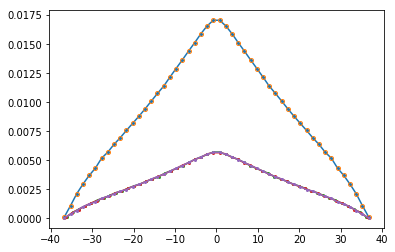

In [34]:
num_bins = 100
# n, bins, patches = plt.hist(v1b, num_bins, facecolor='blue', alpha=0.5)
# plt.show()

# n, bin_edges = np.histogram(vT, bins=num_bins)
# n_sum=np.sum(n)
# bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
# n= n/n_sum/(bin_edges[1]-bin_edges[0])

# num_bins1=50
# n0, bin_edges0 = np.histogram(vT0, bins=num_bins1)
# bins_center0= (bin_edges0[0:num_bins1]+ bin_edges0[1:])/2
# n0= n0/n_sum/(bin_edges0[1]-bin_edges0[0])

n1, bin_edges1 = np.histogram(vT1, bins=num_bins1)
bins_center1= (bin_edges1[0:num_bins1]+ bin_edges1[1:])/2
n1= n1/n_sum/(bin_edges1[1]-bin_edges1[0])


n1200, bin_edges1200 = np.histogram(vT1200, bins=num_bins1)
bins_center1200= (bin_edges1200[0:num_bins1]+ bin_edges1200[1:])/2
n1200= n1200/n_sum/(bin_edges1200[1]-bin_edges1200[0])

n2100, bin_edges2100 = np.histogram(vT2100, bins=num_bins1)
bins_center2100= (bin_edges2100[0:num_bins1]+ bin_edges2100[1:])/2
n2100= n2100/n_sum/(bin_edges2100[1]-bin_edges2100[0])

n1221, bin_edges1221 = np.histogram(vT1221, bins=num_bins1)
bins_center1221= (bin_edges1221[0:num_bins1]+ bin_edges1221[1:])/2
n1221= n1221/n_sum/(bin_edges1221[1]-bin_edges1221[0])

vc=np.concatenate((vT1200,vT2100,vT1221))
nc, bin_edgesc = np.histogram(vc, bins=num_bins1)
bins_centerc= (bin_edgesc[0:num_bins1]+ bin_edgesc[1:])/2
nc= nc/n_sum/(bin_edgesc[1]-bin_edgesc[0])


plt.figure()
# plt.plot(bins_center,n,'o-',markersize=2)
# plt.plot(bins_center0,n0,'o-',markersize=2)
plt.plot(bins_center1,n1,'o-',markersize=2)
plt.plot(bins_centerc,nc,'o',markersize=4,markerfacecolor="None")
plt.plot(bins_center1200,n1200,'o-',markersize=2)
plt.plot(bins_center2100,n2100,'o-',markersize=2)
plt.plot(bins_center1221,n1221,'o-',markersize=2)


plt.show()
